In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
%run '/Users/sabanejad/Projects/demand-response/functions.py'

In [3]:
total_usage_2013 = pd.read_parquet('total_usage_2013.gzip')
total_usage_2014 = pd.read_parquet('total_usage_2014.gzip')

In [4]:
total_usage_2013_sliced = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() <= '2013-02-27')]
total_usage_2014 = total_usage_2014.loc[(total_usage_2014['date_time'].dt.normalize() <= '2014-02-27')]

In [5]:
df_2013_control_sliced = total_usage_2013_sliced.loc[~total_usage_2013_sliced['treated']]
df_2014_control = total_usage_2014.loc[~total_usage_2014['treated']]

In [6]:
# clean the data, remove houses that have more than x% of their hh data missing
def clean_house(df, x):
    missing = df.loc[df.isna().sum(axis=1) / df.shape[1] > 0.01, :].index
    return df.drop(index=missing)

In [ ]:
# clean the data, remove timestamps that have more than x% of their house data missing
def clean_time(df, x):
    missing = df.loc[:, df.isna().sum(axis=0) / df.shape[0] > 0.01].columns
    return df.drop(columns=missing)

what this shows is that after only cleaning the house level data there are time level data that have more than 1% missing
but that the missing fraction isn't that high altogether. so, it's okay.

In [46]:
percent = a_2013_clean.isna().sum(axis=0) / len(a_2013_clean)
percent[percent > 0.01]

date_time
2013-01-09 11:00:00    0.010056
2013-01-18 09:30:00    0.015903
2013-01-29 20:00:00    0.011225
2013-02-10 22:00:00    0.017072
2013-02-19 19:30:00    0.015201
2013-02-25 12:30:00    0.016370
dtype: float64

In [7]:
def house_intersect(a1, a2):

    control_houses = set(a1.index).intersection(set(a2.index))
    
    a1 = a1.loc[a1.index.isin(control_houses)]
    a2 = a2.loc[a2.index.isin(control_houses)]
    
    return a1, a2

In [ ]:
def control_get_matrices_no_nan(c1, c2, x):
    
    a1 = c1.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
    a2 = c2.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
    
    print(a1.shape, a2.shape)
    
    a1 = clean_house(a1, x)
    a2 = clean_house(a2, x)
    
    a1, a2 = house_intersect(a1, a2)
    
    print('after cleaning', a1.shape, a2.shape)
    
    print('percentage of nans:', frac_nans(a1), frac_nans(a2))
    
    return a1, a2

In [156]:
def control_get_matrices(c1, c2, x):
    
    a1 = c1.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
    a2 = c2.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
    
    print(a1.shape, a2.shape)
    
    a1 = clean_house(a1, x)
    a2 = clean_house(a2, x)
    
    a1, a2 = house_intersect(a1, a2)
    
    print('after cleaning', a1.shape, a2.shape)
    
    print('percentage of nans:', frac_nans(a1), frac_nans(a2))
    
    return a1, a2

In [157]:
def frac_nans(mat):
    return round(mat.isna().sum().sum() / (mat.shape[0] * mat.shape[1])*100, 3)

In [158]:
a_2013_sliced_, a_2014_ = control_get_matrices(df_2013_control_sliced, df_2014_control, 0.01)

(4406, 2784) (4065, 2784)
after cleaning (3404, 2784) (3404, 2784)
percentage of nans: 0.018 0.018


In [10]:
# divide along columns by default
# train_size between 0-1
def test_train_split(df, train_size, axis=1):
    all_columns = set(df.columns)
    train = set(random.sample(all_columns, math.floor(train_size * len(all_columns))))
    test = all_columns - train
    return df.loc[:, df.columns.isin(train)], df.loc[:, df.columns.isin(test)]

In [210]:
def find_error(df1, df2, t):
    
    train1_, test1_ = train_test_split(df1, train_size=t, random_state=220)
    train2_, test2_ = train_test_split(df2, train_size=t, random_state=220)
    
    n=0
    train1 = impute(train1_.iloc[n:, :].values, np.nanmedian, 1)
    test1 = impute(test1_.iloc[n:, :].values, np.nanmedian, 1)
    train2 = impute(train2_.iloc[n:, :].values, np.nanmedian, 1)
    test2 = impute(test2_.iloc[n:, :].values, np.nanmedian, 1)
    
    train1_inv = np.linalg.pinv(train1)
    X = train1_inv @ train2
    test2_est = test1 @ X
    
#     return math.sqrt(mean_squared_error(test2.flatten(), test2_est.flatten()))
#     return rmspe(np.ma.masked_invalid(test2.flatten()), np.ma.masked_invalid(test2_est.flatten()))
    return rmspe(np.ma.masked_invalid(test2.mean(axis=0)), np.ma.masked_invalid(test2_est.mean(axis=0)))
#     return test2_, test2_est

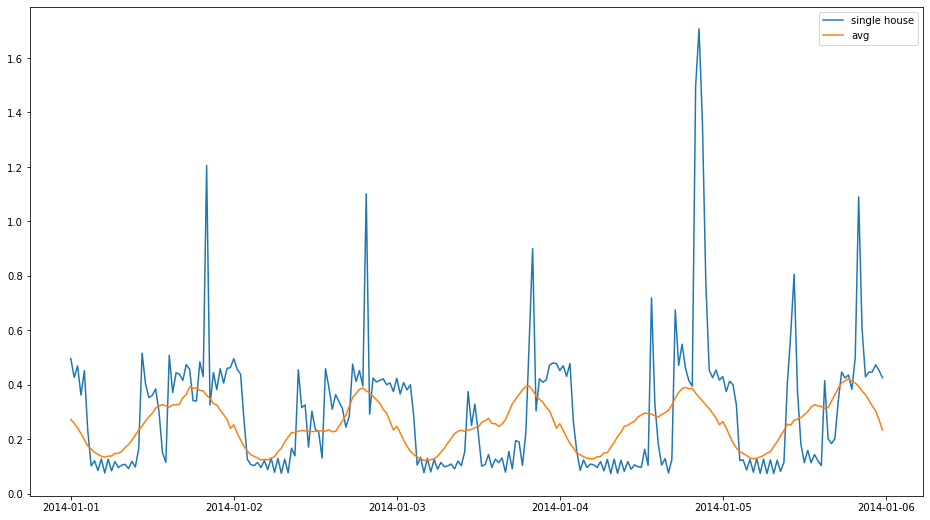

In [204]:
plt.figure(figsize=(16, 9))
n=5
plt.plot(a_2014_.iloc[0][:48*n], label='single house')
plt.plot(a_2014_.mean(axis=0)[:48*n], label='avg')
plt.legend()
plt.show()

In [168]:
test, test_est = find_error(a_2013_sliced_, a_2014_, 0.7)

In [170]:
test_est = pd.DataFrame(test_est, columns=test.iloc[n:, :].columns, index=test.iloc[n:, :].index)

In [209]:
test.mean(axis=0).isna().sum().sum()

0

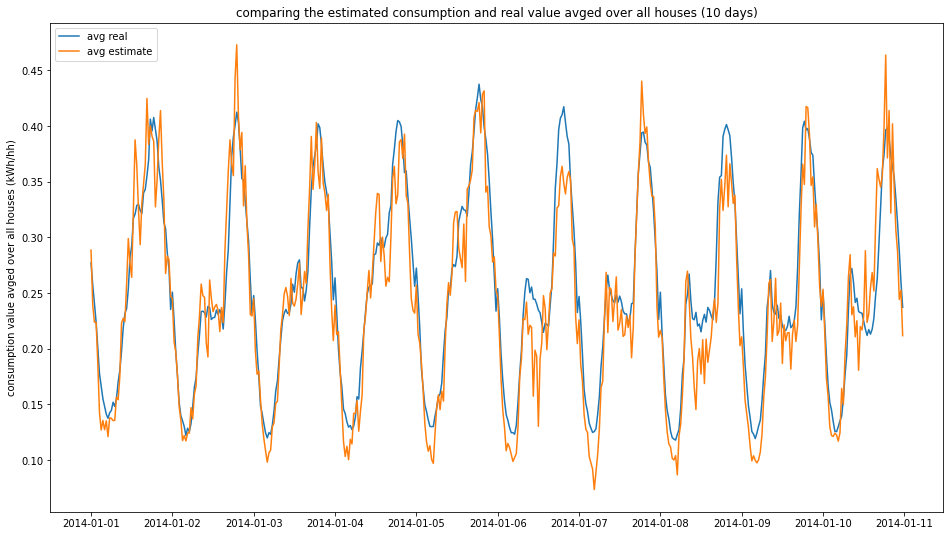

In [218]:
plt.figure(figsize=(16, 9))
# number of days
n=10

plt.plot(test.mean(axis=0)[:48*n], label='avg real')
plt.plot(test_est.mean(axis=0)[:48*n], label='avg estimate')
plt.ylabel('consumption value avged over all houses (kWh/hh)')
plt.title('comparing the estimated consumption and real value avged over all houses (10 days)')
plt.legend()
plt.show()

In [207]:
rmspe(test.mean(axis=0), test_est.mean(axis=0))

12.926445030646352

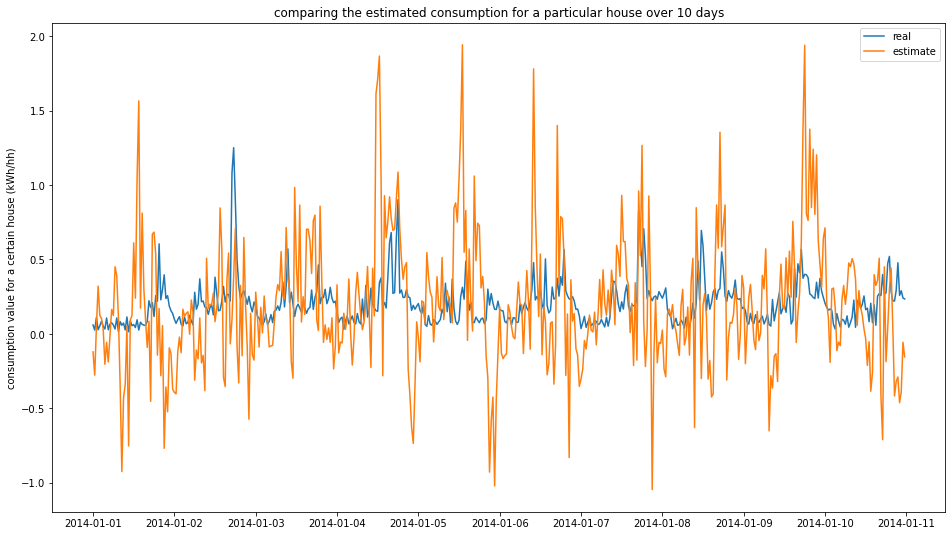

In [219]:
plt.figure(figsize=(16, 9))
# number of days
n=10

plt.plot(test.iloc[0][:48*n], label='real')
plt.plot(test_est.iloc[0][:48*n], label='estimate')
plt.ylabel('consumption value for a certain house (kWh/hh)')
plt.title('comparing the estimated consumption for a particular house over 10 days')
plt.legend()
plt.show()

In [211]:
train_sizes = np.arange(0.6, 0.95, 0.05)
Error = []
for t in train_sizes:
    Error.append(find_error(a_2013_sliced_, a_2014_, t))

In [85]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

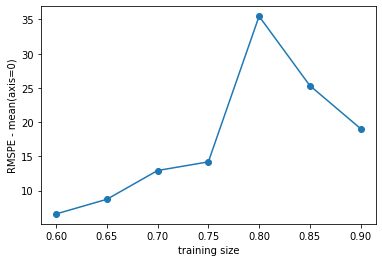

In [212]:
plt.plot(train_sizes, Error, '-o')
plt.ylabel('RMSPE - mean(axis=0)')
plt.xlabel('training size');

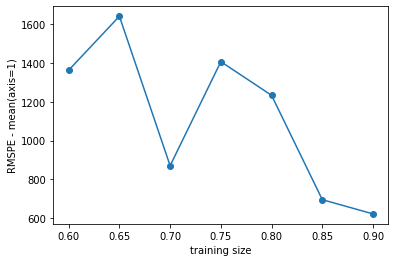

In [133]:
plt.plot(train_sizes, MSE, '-o')
plt.ylabel('RMSPE - mean(axis=1)')
plt.xlabel('training size');

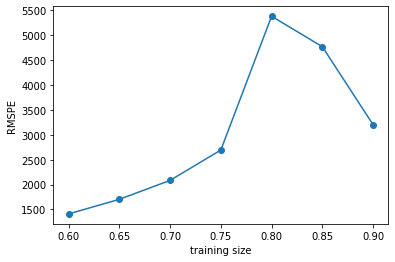

In [129]:
plt.plot(train_sizes, MSE, '-o')
plt.ylabel('RMSPE')
plt.xlabel('training size');

In [134]:
transform_KWH(0.6)

=  123.07692307692308 hours of TV
=  128.0 hours of fridge
=  112.94117647058823 hours of washing machine
=  10.32258064516129 hours of dryer
=  8.228571428571428 hours of AC


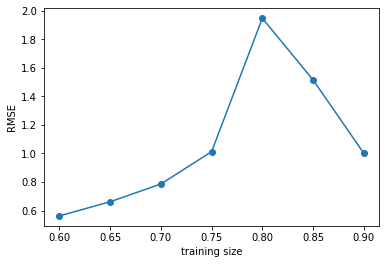

In [125]:
plt.plot(train_sizes, MSE, '-o')
plt.ylabel('RMSE')
plt.xlabel('training size');